In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms, datasets, utils

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
mnist_data = datasets.MNIST(root='.', train=True, download=True,
                            transform=transforms.Compose([transforms.ToTensor(),
                                                          transforms.Normalize([0.5], [0.5])]))
mnist_data_loader = torch.utils.data.DataLoader(mnist_data, batch_size=128, drop_last=True, shuffle=True)

In [3]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

discriminator = DiscriminatorNet()

In [4]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

generator = GeneratorNet()

In [5]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=2e-4)
g_optimizer = optim.Adam(generator.parameters(), lr=2e-4)

In [6]:
def train_discriminator(discriminator, optimizer, real_data, fake_data):
    input_data = torch.cat([real_data, fake_data], dim=0)
    targets    = torch.cat([torch.ones(real_data.size(0), 1), torch.zeros(fake_data.size(0), 1)], dim=0)

    preds = discriminator(input_data)

    loss = F.binary_cross_entropy(preds, targets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

In [7]:
def train_generator(optimizer, fake_data):
    preds = discriminator(fake_data)

    loss = F.binary_cross_entropy(preds, torch.ones(fake_data.size(0), 1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

Epoch 0
    Discriminator Loss: 0.574147
    Generator Loss: 1.904955
---------------------

Epoch 9
    Discriminator Loss: 0.270587
    Generator Loss: 2.500291
---------------------

Epoch 19
    Discriminator Loss: 0.377398
    Generator Loss: 1.986568
---------------------

Epoch 29
    Discriminator Loss: 0.470961
    Generator Loss: 1.525718
---------------------

Epoch 39
    Discriminator Loss: 0.509689
    Generator Loss: 1.378818
---------------------

Epoch 49
    Discriminator Loss: 0.538310
    Generator Loss: 1.253391
---------------------

Epoch 59
    Discriminator Loss: 0.572761
    Generator Loss: 1.130554
---------------------

Epoch 69
    Discriminator Loss: 0.584078
    Generator Loss: 1.081733
---------------------

Epoch 79
    Discriminator Loss: 0.597147
    Generator Loss: 1.040017
---------------------

Epoch 89
    Discriminator Loss: 0.606942
    Generator Loss: 0.994049
---------------------

Epoch 99
    Discriminator Loss: 0.613355
    Generator Loss: 

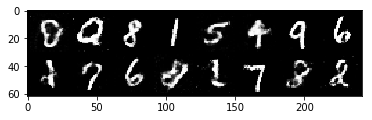

In [8]:
n_epochs = 200

n_test_samples = 16
test_noise = torch.randn(n_test_samples, 100)

n_batches = len(mnist_data_loader)

avg_d_losses = []
avg_g_losses = []
for i_epoch in range(n_epochs):
    running_d_loss = 0.
    running_g_loss = 0.
    for n_batch, (real_batch,_) in enumerate(mnist_data_loader):
        real_data = real_batch.view(-1, 784)
        fake_data = generator(torch.randn(real_data.size(0), 100))

        # Train D
        running_d_loss += train_discriminator(discriminator, d_optimizer, real_data, fake_data.detach())

        # Train G
        running_g_loss += train_generator(g_optimizer, fake_data)

    avg_d_losses.append(running_d_loss / n_batches)
    avg_g_losses.append(running_g_loss / n_batches)

    if i_epoch == 0 or (i_epoch + 1) % 10 == 0:
        with torch.no_grad():
            test_images = generator(test_noise).view(-1, 1, 28, 28)
        utils.save_image(test_images, "test_samples/epoch_{:d}.png".format(i_epoch), nrow=8, normalize=True, range=(-1, 1))
        print("Epoch {:d}".format(i_epoch))
        print("=====================")
        print("    Discriminator Loss: {:f}".format(avg_d_losses[-1]))
        print("    Generator Loss: {:f}".format(avg_g_losses[-1]))
        print("---------------------")
        print()

plt.imshow(utils.make_grid(test_images, nrow=8, normalize=True, range=(-1, 1)).permute(1, 2, 0));

---